<center><h1>SC09 Dataset with GLU</h1></center>

In [1]:
%matplotlib inline
# Built-in IPython extension to reload modules when updated.
%load_ext autoreload
%autoreload 2

In [2]:
import torch
from torch import nn
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from tqdm.auto import tqdm
import copy
import IPython.display as ipd
from torchaudio.functional import mu_law_encoding, mu_law_decoding
from scipy.io import wavfile

# Custom modules
from sashimi import *
from wav_dataset import *

Using PyKeOps Cauchy kernel.


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = torch.device("cpu")
device

device(type='cuda')

# Dataset

SC09 is a dataset containing 1 second audio recordings of spoken digits, 0 to 9.

In [4]:
train_dataset = SC09("../datasets/sc09/train", device=device)

WAV files in directory: 5965
729 WAV file(s) were discarded because they were not 1 second long.


In [5]:
len(train_dataset)

5236

In [6]:
x, y = train_dataset[0]
assert list(x.size()) == [16000]
assert list(y.size()) == [16000]

`y` contains all samples 0 to N in the sound file, each sample is an integer between 0 and 255. `x`, on the other hand, contains samples 0 to N-1, each sample is an integer between 0 to 255. For each input sample $i$, the network predicts the probabilities for the next sample ($i+1$) in 8-bits using the inputs from $0$ to $i$.

# Full Dataset Training

- After the start of epoch 110, we reduced the LR from 0.001 to 0.0001.

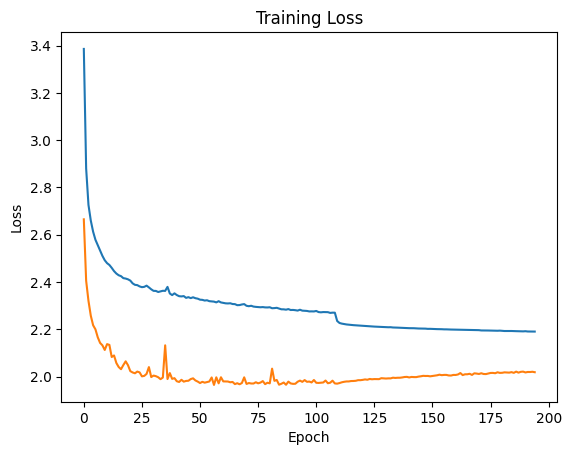

In [7]:
train = [3.385939121246338, 2.880284070968628, 2.7263553142547607, 2.6599416732788086, 2.6128995418548584, 2.578711748123169, 2.5556845664978027, 2.5321812629699707, 2.510728597640991, 2.4922001361846924, 2.479898691177368, 2.4722352027893066, 2.4600119590759277, 2.4462552070617676, 2.4359097480773926, 2.4287309646606445, 2.424922227859497, 2.4165737628936768, 2.414750576019287, 2.411533832550049, 2.406121015548706, 2.3944451808929443, 2.3882205486297607, 2.386991500854492, 2.3815219402313232, 2.3783576488494873, 2.379739999771118, 2.38476824760437, 2.377354621887207, 2.3692831993103027, 2.362781047821045, 2.36244797706604, 2.3579447269439697, 2.3602817058563232, 2.363083600997925, 2.362557888031006, 2.379574775695801, 2.351577043533325, 2.3448245525360107, 2.3522465229034424, 2.345045566558838, 2.3401825428009033, 2.339277505874634, 2.340611696243286, 2.333099126815796, 2.3360862731933594, 2.332007646560669, 2.335578203201294, 2.331723928451538, 2.329749345779419, 2.325493812561035, 2.324700117111206, 2.3218297958374023, 2.322944164276123, 2.3191418647766113, 2.318204164505005, 2.3172032833099365, 2.3139805793762207, 2.3190317153930664, 2.3138065338134766, 2.3119966983795166, 2.310015916824341, 2.3094842433929443, 2.310256242752075, 2.307080030441284, 2.3065896034240723, 2.302210569381714, 2.302644968032837, 2.305121421813965, 2.306748151779175, 2.2995758056640625, 2.297847032546997, 2.299670457839966, 2.296260356903076, 2.295003890991211, 2.2944092750549316, 2.2933871746063232, 2.2941393852233887, 2.2928173542022705, 2.2925639152526855, 2.2934012413024902, 2.2892658710479736, 2.2898612022399902, 2.291041851043701, 2.2878270149230957, 2.2847540378570557, 2.284595012664795, 2.2831783294677734, 2.2856438159942627, 2.281759023666382, 2.282092809677124, 2.280977964401245, 2.2793192863464355, 2.28291654586792, 2.2791073322296143, 2.2785966396331787, 2.2778408527374268, 2.275761842727661, 2.27597975730896, 2.2757115364074707, 2.277717351913452, 2.2730493545532227, 2.2719624042510986, 2.273074150085449, 2.2727880477905273, 2.2726516723632812, 2.269550323486328, 2.270582437515259, 2.270416021347046, 2.235377311706543, 2.2269198894500732, 2.2241618633270264, 2.2222514152526855, 2.2206943035125732, 2.219604253768921, 2.218663454055786, 2.217695951461792, 2.2169859409332275, 2.2159721851348877, 2.215730905532837, 2.2145164012908936, 2.213975667953491, 2.2132766246795654, 2.212782859802246, 2.212458610534668, 2.211618423461914, 2.211151123046875, 2.2109181880950928, 2.210308313369751, 2.2097713947296143, 2.2093076705932617, 2.208836793899536, 2.2090327739715576, 2.2078471183776855, 2.207669496536255, 2.207185983657837, 2.206697940826416, 2.2063169479370117, 2.2058541774749756, 2.205591917037964, 2.2049379348754883, 2.2049272060394287, 2.2047247886657715, 2.2039778232574463, 2.2035253047943115, 2.203342914581299, 2.2033915519714355, 2.202993392944336, 2.2020151615142822, 2.2021520137786865, 2.201615571975708, 2.201451063156128, 2.2009270191192627, 2.2008132934570312, 2.200528621673584, 2.1999669075012207, 2.1999053955078125, 2.1993606090545654, 2.1991472244262695, 2.1988954544067383, 2.19858980178833, 2.198622941970825, 2.198122501373291, 2.1978673934936523, 2.197622060775757, 2.196990728378296, 2.1967670917510986, 2.1968891620635986, 2.1962571144104004, 2.1962389945983887, 2.196568489074707, 2.1953182220458984, 2.195343255996704, 2.1951730251312256, 2.195005416870117, 2.194809913635254, 2.194450855255127, 2.1941428184509277, 2.1940314769744873, 2.194524049758911, 2.193666934967041, 2.1929211616516113, 2.1931405067443848, 2.1929380893707275, 2.1929967403411865, 2.1924123764038086, 2.19228196144104, 2.192067861557007, 2.1918530464172363, 2.191423177719116, 2.192089080810547, 2.1909148693084717, 2.190816879272461, 2.19059681892395, 2.1905651092529297]
valid = [2.6652536392211914, 2.405484437942505, 2.320460081100464, 2.2575109004974365, 2.217362642288208, 2.1999409198760986, 2.166184186935425, 2.1425764560699463, 2.1323885917663574, 2.1127827167510986, 2.137403964996338, 2.134273052215576, 2.083120107650757, 2.0895984172821045, 2.057636022567749, 2.040682554244995, 2.0313754081726074, 2.0489470958709717, 2.064687490463257, 2.0483431816101074, 2.02325177192688, 2.017636299133301, 2.0141773223876953, 2.0213634967803955, 2.0178823471069336, 2.00119948387146, 2.0031423568725586, 2.0115904808044434, 2.0403449535369873, 1.9982702732086182, 2.004444122314453, 2.0019869804382324, 1.9973965883255005, 1.989324688911438, 1.996050238609314, 2.132448196411133, 1.989771842956543, 2.0149896144866943, 1.990580439567566, 1.9935165643692017, 1.9805195331573486, 1.9774374961853027, 1.986594796180725, 1.978838562965393, 1.9818754196166992, 1.9825469255447388, 1.989684820175171, 1.9927884340286255, 1.9839019775390625, 1.9790645837783813, 1.9728773832321167, 1.9780510663986206, 1.9745298624038696, 1.9771223068237305, 1.9793944358825684, 1.9964970350265503, 1.9649380445480347, 1.9970874786376953, 1.9716379642486572, 1.9973011016845703, 1.9798797369003296, 1.9794425964355469, 1.979314923286438, 1.9761667251586914, 1.9774975776672363, 1.9684041738510132, 1.9721676111221313, 1.9676501750946045, 1.9729363918304443, 1.9970154762268066, 1.9691176414489746, 1.9729299545288086, 1.9709696769714355, 1.9708783626556396, 1.9762439727783203, 1.9717451333999634, 1.974812626838684, 1.9811512231826782, 1.9682695865631104, 1.9742395877838135, 1.9716025590896606, 2.0338382720947266, 1.9821503162384033, 1.985921025276184, 1.9658799171447754, 1.969863772392273, 1.9750301837921143, 1.9656027555465698, 1.9789007902145386, 1.9713099002838135, 1.969427227973938, 1.9698632955551147, 1.978460431098938, 1.9831851720809937, 1.9779263734817505, 1.9854248762130737, 1.9781231880187988, 1.9791598320007324, 1.9754220247268677, 1.9857428073883057, 1.9739446640014648, 1.9733258485794067, 1.974393606185913, 1.9752674102783203, 1.9834372997283936, 1.9720648527145386, 1.9743109941482544, 1.9829143285751343, 1.9712399244308472, 1.9703216552734375, 1.972819209098816, 1.9760289192199707, 1.978161096572876, 1.9795969724655151, 1.9796732664108276, 1.981378197669983, 1.9816135168075562, 1.9824162721633911, 1.9849909543991089, 1.984953761100769, 1.9863049983978271, 1.9882192611694336, 1.9868615865707397, 1.9901108741760254, 1.9888185262680054, 1.9896774291992188, 1.9896514415740967, 1.9893430471420288, 1.9934035539627075, 1.9924999475479126, 1.9919089078903198, 1.9926443099975586, 1.9926074743270874, 1.9954900741577148, 1.9944870471954346, 1.9952398538589478, 1.9953311681747437, 1.9966051578521729, 1.9984455108642578, 1.9989718198776245, 1.9965770244598389, 1.9986677169799805, 1.998046636581421, 1.997936487197876, 2.0000808238983154, 2.0014429092407227, 2.003349781036377, 2.0027260780334473, 2.0029001235961914, 2.0012805461883545, 2.0027384757995605, 2.0042355060577393, 2.005667209625244, 2.0082626342773438, 2.006188154220581, 2.007319927215576, 2.0072896480560303, 2.004953622817993, 2.0046520233154297, 2.0072033405303955, 2.0070667266845703, 2.009200096130371, 2.0151724815368652, 2.006561279296875, 2.009897232055664, 2.0099937915802, 2.0120480060577393, 2.0072288513183594, 2.0139992237091064, 2.0129234790802, 2.011223316192627, 2.0142760276794434, 2.01120924949646, 2.0107855796813965, 2.013327121734619, 2.015559673309326, 2.0157597064971924, 2.014420986175537, 2.0183639526367188, 2.015819549560547, 2.0162670612335205, 2.018118381500244, 2.01737117767334, 2.016899585723877, 2.018998622894287, 2.0160179138183594, 2.021284818649292, 2.0168545246124268, 2.020320415496826, 2.021184206008911, 2.0177295207977295, 2.019669532775879, 2.0195298194885254, 2.020610809326172, 2.0186965465545654]

plt.title(label="Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.plot(train)
plt.plot(valid)

# Loading a Pre-Trained Model

Let's load the second pre-trained model. Note that you should have downloaded this model using `download_data.sh`.
Note that there are other pre-trained models in `models` folder.

In [16]:
checkpoint = torch.load("../models/sc09-glu/epoch0109.pt", map_location=device)

model = SaShiMi(
    input_dim=1,
    hidden_dim=64,
    output_dim=256,
    state_dim=64,
    sequence_length=16000,
    block_count=8,
    block_class=S4BlockGLU,
    encoder=Embedding(256, 64),
).to(device)

model.load_state_dict(checkpoint["model_state"])

<All keys matched successfully>

Now, let's sample from this model that has been trained on the full SC09 dataset.

In [17]:
def generate_sample(m, count: int, priming_signal=None, maxp=False):
    f = m.get_recurrent_runner()
    # The input is padded with 0 at the start
    u = f(mu_law_encoding(torch.zeros(1, device=device), 256))

    # Process the priming signal if given
    if priming_signal is not None:
        for s in priming_signal:
            u = f(s)
        primed_size = priming_signal.size(0)
    else:
        primed_size = 0

    # Generate the new part
    Y = []
    for _ in tqdm(range(count - primed_size), leave=False):
        if maxp:
            p = torch.argmax(u)
        else:
            dist = torch.distributions.categorical.Categorical(probs=torch.nn.functional.softmax(u, dim=-1))
            p = dist.sample()
        Y.append(p)
        u = p.reshape(1)
        u = f(u)

    generated = torch.stack(Y).real
    if priming_signal is not None:
        priming_signal = priming_signal.flatten()
        return torch.cat([priming_signal, generated], dim=0)
    else:
        return generated

  0%|          | 0/16000 [00:00<?, ?it/s]

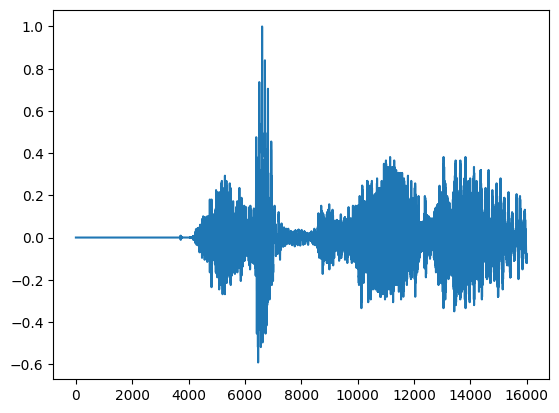

In [23]:
torch.manual_seed(42)
model.eval()
with torch.no_grad():
    #gen = generate_sample(model, 16000, train_dataset[1][0][:8000])
    gen = generate_sample(model, 16000).flatten()
    gen = mu_law_decoding(gen, 256).cpu()

plt.figure()
plt.plot(gen)
ipd.Audio(gen.numpy(), rate=16000)

In [24]:
wavfile.write("outputs/sc09-glu/epoch109-seed42.wav", 16000, gen.numpy())

Generate en masse.

In [20]:
model.eval()
for i in tqdm(range(11), leave=False):
    torch.manual_seed(i)
    with torch.no_grad():
        gen = generate_sample(model, 16000).flatten()
        gen = mu_law_decoding(gen, 256).cpu()
    wavfile.write(f"outputs/sc09-glu/epoch109-seed{i}.wav", 16000, gen.numpy())

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/16000 [00:00<?, ?it/s]

  0%|          | 0/16000 [00:00<?, ?it/s]

  0%|          | 0/16000 [00:00<?, ?it/s]

  0%|          | 0/16000 [00:00<?, ?it/s]

  0%|          | 0/16000 [00:00<?, ?it/s]

  0%|          | 0/16000 [00:00<?, ?it/s]

  0%|          | 0/16000 [00:00<?, ?it/s]

  0%|          | 0/16000 [00:00<?, ?it/s]

  0%|          | 0/16000 [00:00<?, ?it/s]

  0%|          | 0/16000 [00:00<?, ?it/s]

  0%|          | 0/16000 [00:00<?, ?it/s]

# Reproducing the Results

## NLL Test

Next, we will compute negative log likelihood (NLL) values on the test dataset.

In [21]:
test_dataset = SC09("../datasets/sc09/test", device=device)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)
len(test_dataset)

WAV files in directory: 742
85 WAV file(s) were discarded because they were not 1 second long.


657

Note that [CrossEntropyLoss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html) simply calculates the NLL by applying softmax internally:

$$
l_n = - \log \frac{\exp(x_{n,y_n})}{\sum_{c=1}^C \exp(x_{n,c})}
$$

Note that PyTorch uses natural log by default. We convert this to NLL in bits by dividing the result by $\log(2)$. 

In [22]:
model.eval()
criterion = torch.nn.CrossEntropyLoss()
with torch.no_grad():
    nll = 0.0
    for x, y in tqdm(test_dataloader, leave=False):
        y_hat = model(x)
        nll += criterion(y_hat.view(-1, 256), y.view(-1))
    nll /= len(test_dataloader)

    print("Average NLL:", nll.item())
    print("Average NLL in base 2:", (nll / torch.tensor(2.0).log()).item())
    print("Average NLL converted to probability:", (-nll).exp().item())

  0%|          | 0/657 [00:00<?, ?it/s]

Average NLL: 2.0140774250030518
Average NLL in base 2: 2.9056994915008545
Average NLL converted to probability: 0.1334434449672699


Our test NLL in bits is worse than the values reported in the paper.

Epoch 109 (before LR reduction):
```
Average NLL: 2.0140774250030518
Average NLL in base 2: 2.9056994915008545
Average NLL converted to probability: 0.1334434449672699
```

Epoch 195:
```
Average NLL: 2.069626808166504
Average NLL in base 2: 2.985840320587158
Average NLL converted to probability: 0.12623287737369537
```